In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from data.image import CS_Images
from data.config import BRAIN_VISA_PATH, CS_CORRECTED
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

import SimpleITK as sitk

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
cs_paths = [x for x in Path(BRAIN_VISA_PATH).glob(CS_CORRECTED)]
dataset = CS_Images(segmentation='all',
                    mesh=True,
                    preload=False)

Found 308 subjects and 308 MPRAGE images
Found 13 subjects with both BrainVisa and corrected from 308 subjects


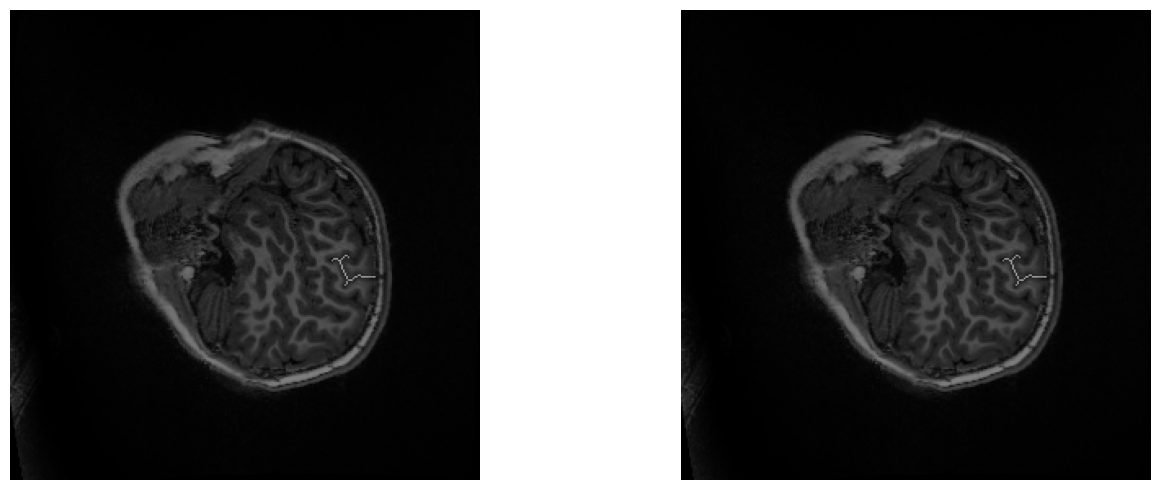

In [3]:
s0 = dataset[1]
img = sitk.GetArrayFromImage(s0['img'])
bvisa = sitk.GetArrayFromImage(s0['bvisa'])
corrected = sitk.GetArrayFromImage(s0['corrected'])
caseid = s0['caseid']
center = s0['centre']
slc = 40

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(img[slc, :, :].T, cmap='gray')
axs[0].imshow(bvisa[slc, :, :].T, alpha=0.5, cmap='gray')
axs[0].set_axis_off()

axs[1].imshow(img[slc, :, :].T, cmap='gray')
axs[1].imshow(corrected[slc, :, :].T, alpha=0.5, cmap='gray')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

In [4]:
bvisa_pcd = np.stack((bvisa==1).nonzero()).T
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(bvisa_pcd[:,:3])
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd])


In [5]:
o3d.visualization.draw_geometries_with_custom_animation([s0['bvisa_mesh_lscl'],
                                   s0['bvisa_mesh_rscl']])


In [5]:
clust_idx, triangl_per_clust, srf_are_per_clust = s0['bvisa_mesh_rscl'].cluster_connected_triangles()
print(f'Found {len(triangl_per_clust)} clusters with {srf_are_per_clust} triangles and {srf_are_per_clust} surface area')

Found 1 clusters with DoubleVector[3537] triangles and DoubleVector[3537] surface area


In [7]:
srf_area = np.sum(srf_are_per_clust)
volume = s0['bvisa_mesh_rscl'].get_volume()
print(s0['bvisa_mesh_rscl'].is_self_intersecting())
print(s0['bvisa_mesh_rscl'].is_watertight())


False
True


In [11]:
mesh = o3d.t.geometry.TriangleMesh.from_legacy(s0['bvisa_mesh_rscl'])
filled = mesh.fill_holes().to_legacy()
filled_volume = filled.get_volume()
print(f'Filled volume: {filled_volume} vs original volume: {volume}')

Filled volume: 1272.343761531596 vs original volume: 1272.343761531596


In [16]:
o3d.visualization.draw_geometries_with_custom_animation([filled,
                                                         s0['bvisa_mesh_rscl']])
